
Feature Selection Comparison:
   FeatureSelection         Model  #Features  CV_Accuracy     CV_F1  CV_AUC  \
0               MiG        LogReg        421     1.000000  1.000000     1.0   
1               MiG           SVM        421     1.000000  1.000000     1.0   
2               MiG  RandomForest        421     1.000000  1.000000     1.0   
3               MiG       XGBoost        421     0.995238  0.997436     1.0   
4             ANOVA        LogReg        421     1.000000  1.000000     1.0   
5             ANOVA           SVM        421     1.000000  1.000000     1.0   
6             ANOVA  RandomForest        421     1.000000  1.000000     1.0   
7             ANOVA       XGBoost        421     0.995238  0.997436     1.0   
8             LASSO        LogReg        421     1.000000  1.000000     1.0   
9             LASSO           SVM        421     1.000000  1.000000     1.0   
10            LASSO  RandomForest        421     1.000000  1.000000     1.0   
11            LASSO  

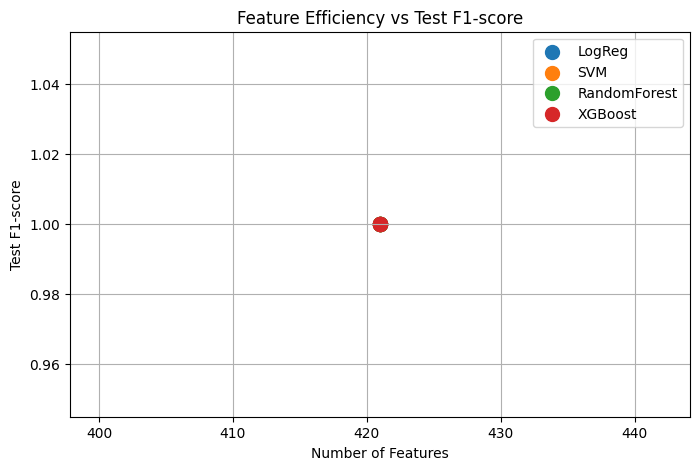

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# ===================
# CONFIGURATION
# ===================
N_SPLITS = 10
RANDOM_STATE = 84
TEST_SIZE = 0.2

# Simple models for FS comparison
MODELS = {
    "LogReg": LogisticRegression(
        penalty="l2",
        C=1.0,  # tuned to avoid over-regularization
        max_iter=5000,
        solver="liblinear",
        multi_class="ovr",
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "SVM": SVC(
        kernel="rbf",       # better than sigmoid
        C=0.5,
        gamma="scale",
        probability=True,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
     "RandomForest": RandomForestClassifier(
            n_estimators=500,        # try 100, 300, 500, 1000
            criterion="log_loss",    # try "gini", "entropy", "log_loss"
            max_depth=3,             # try None, 5, 10, 20
            min_samples_split=10,    # try 2, 5, 10
            min_samples_leaf=10,     # try 1, 2, 4
            max_features=0.1,        # try "sqrt", "log2", 0.5, None
            bootstrap=True,          # try True, False
            oob_score=True,          # enables out-of-bag validation
            class_weight="balanced", # handle imbalance
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),

    "XGBoost": XGBClassifier(
            n_estimators=300,
            learning_rate=0.03,
            max_depth=2,
            subsample=0.6,
            colsample_bytree=0.4,
            reg_alpha=5,
            reg_lambda=10,
            min_child_weight=10,
            gamma=5,
            scale_pos_weight=12,
            eval_metric="logloss",
            random_state=RANDOM_STATE,
            n_jobs=-1,
            use_label_encoder=False
        )
}

# ===================
# Cross-validation function
# ===================
def cross_validate_model(model, X_train, y_train, scale=False):
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    acc_scores, f1_scores, auc_scores = [], [], []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Scale if needed
        if scale:
            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_tr)
            X_val = scaler.transform(X_val)

        # Compute class weights
        sample_weights = compute_sample_weight(class_weight="balanced", y=y_tr)

        # Fit model
        model.fit(X_tr, y_tr, sample_weight=sample_weights)

        # Predict
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]

        # Metrics
        acc_scores.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, zero_division=0))
        auc_scores.append(roc_auc_score(y_val, y_prob))

    return {
        "Accuracy": np.mean(acc_scores),
        "F1": np.mean(f1_scores),
        "AUC": np.mean(auc_scores)
    }

# ===================
# Full evaluation pipeline
# ===================
def evaluate_feature_selection(files_dict):
    all_results = []

    for method_name, file_path in files_dict.items():
        df = pd.read_csv(file_path)
        X = df.drop(columns=["Class"])
        y = df["Class"].astype(int).values
        n_features = X.shape[1]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
        )

        for model_name, model in MODELS.items():
            # Scale for SVM
            scale = model_name == "SVM"
            cv_scores = cross_validate_model(model, X_train, y_train, scale=scale)

            # Fit on full train and test
            if scale:
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                model.fit(X_train_scaled, y_train, sample_weight=compute_sample_weight(class_weight="balanced", y=y_train))
                y_pred_test = model.predict(X_test_scaled)
                y_prob_test = model.predict_proba(X_test_scaled)[:, 1]
            else:
                model.fit(X_train, y_train, sample_weight=compute_sample_weight(class_weight="balanced", y=y_train))
                y_pred_test = model.predict(X_test)
                y_prob_test = model.predict_proba(X_test)[:, 1]

            test_scores = {
                "Test_Accuracy": accuracy_score(y_test, y_pred_test),
                "Test_F1": f1_score(y_test, y_pred_test, zero_division=0),
                "Test_AUC": roc_auc_score(y_test, y_prob_test)
            }

            all_results.append({
                "FeatureSelection": method_name,
                "Model": model_name,
                "#Features": n_features,
                "CV_Accuracy": cv_scores["Accuracy"],
                "CV_F1": cv_scores["F1"],
                "CV_AUC": cv_scores["AUC"],
                **test_scores
            })

    return pd.DataFrame(all_results)

# ===================
# Run pipeline
# ===================
files = {
    "MiG": "/kaggle/input/ready-to-classifier/combined_top421_common_genes_mig.csv",
    "ANOVA": "/kaggle/input/ready-to-classifier/combined_top421_common_genes_anova.csv",
    "LASSO": "/kaggle/input/ready-to-classifier/combined_top421_common_genes_lasso.csv",
    "mRMR+SVMRFE": "/kaggle/input/tittititit/combined_top421_common_genes_mrmrsvmrfe.csv"
}

results_df = evaluate_feature_selection(files)
print("\nFeature Selection Comparison:")
print(results_df)

# ===================
# Optional: plot #Features vs Test_F1
# ===================
plt.figure(figsize=(8,5))
for model in MODELS.keys():
    df_plot = results_df[results_df["Model"]==model]
    plt.scatter(df_plot["#Features"], df_plot["Test_F1"], label=model, s=100)
plt.xlabel("Number of Features")
plt.ylabel("Test F1-score")
plt.title("Feature Efficiency vs Test F1-score")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# ===================
# CONFIGURATION
# ===================
N_SPLITS = 10
RANDOM_STATE = 84
TEST_SIZE = 0.2

# Define models
MODELS = {
    "LogReg": LogisticRegression(
            penalty="l2",            # Regularization type ("l1", "l2", "elasticnet", "none")
            C=0.1,                  # Inverse of regularization strength (smaller → stronger regularization)
            max_iter=3000,           # Max number of iterations (increase if convergence warning appears)
            solver="liblinear",      # Solver to use ("liblinear", "saga", "lbfgs", "newton-cg", "sag")
            multi_class="ovr",       # "ovr" = one-vs-rest (good for imbalanced), "multinomial" for many classes
            class_weight="balanced"  # Balance weights automatically
    ),

    "SigmoidSVM": SVC(
            kernel="linear",        # or use "rbf"
            C=0.1,                  # stronger regularization
            gamma="auto",           # or use "auto"
            probability=True,        # needed for ROC-AUC
            class_weight="balanced", # handle class imbalance
            random_state=RANDOM_STATE
        ),

    "RandomForest": RandomForestClassifier(
            n_estimators=500,        # try 100, 300, 500, 1000
            criterion="log_loss",    # try "gini", "entropy", "log_loss"
            max_depth=3,             # try None, 5, 10, 20
            min_samples_split=10,    # try 2, 5, 10
            min_samples_leaf=10,     # try 1, 2, 4
            max_features=0.1,        # try "sqrt", "log2", 0.5, None
            bootstrap=True,          # try True, False
            oob_score=True,          # enables out-of-bag validation
            class_weight="balanced", # handle imbalance
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),

    "XGBoost": XGBClassifier(
            n_estimators=300,
            learning_rate=0.03,
            max_depth=2,
            subsample=0.6,
            colsample_bytree=0.4,
            reg_alpha=5,
            reg_lambda=10,
            min_child_weight=10,
            gamma=5,
            scale_pos_weight=12,
            eval_metric="logloss",
            random_state=RANDOM_STATE,
            n_jobs=-1,
            use_label_encoder=False
        )
}


# ===================
# CV Evaluation Function
# ===================
def cross_validate_model(model, X_train, y_train):
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    acc_scores, prec_scores, rec_scores, f1_scores, auc_scores = [], [], [], [], []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Compute class weights for imbalance
        sample_weights = compute_sample_weight(class_weight="balanced", y=y_tr)

        # Fit model
        model.fit(X_tr, y_tr, sample_weight=sample_weights)

        # Predict
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]

        # Metrics
        acc_scores.append(accuracy_score(y_val, y_pred))
        #prec_scores.append(precision_score(y_val, y_pred))
        #rec_scores.append(recall_score(y_val, y_pred))
        #f1_scores.append(f1_score(y_val, y_pred))
        prec_scores.append(precision_score(y_val, y_pred, zero_division=0))
        rec_scores.append(recall_score(y_val, y_pred, zero_division=0))
        f1_scores.append(f1_score(y_val, y_pred, zero_division=0))
        auc_scores.append(roc_auc_score(y_val, y_prob))

    return {
        "Accuracy": np.mean(acc_scores),
        "Precision": np.mean(prec_scores),
        "Recall": np.mean(rec_scores),
        "F1": np.mean(f1_scores),
        "AUC": np.mean(auc_scores)
    }

# ===================
# Full Pipeline Function
# ===================
def evaluate_feature_selection_methods(files_dict):
    """
    files_dict = {
        "MiG":        "/kaggle/input/ready-to-classifier/combined_top421_common_genes_mig.csv",
        "ANOVA":      "/kaggle/input/ready-to-classifier/combined_top421_common_genes_anova.csv",
        "LASSO":      "/kaggle/input/ready-to-classifier/combined_top421_common_genes_lasso.csv",
        "mRMR+SVMRFE":"/kaggle/input/tittititit/combined_top421_common_genes_mrmrsvmrfe.csv",
    }
    """
    all_results = []

    for method_name, file_path in files_dict.items():
        print(f"\nProcessing Feature Selection Method: {method_name}")
        df = pd.read_csv(file_path)
        X = df.drop(columns=["Class"])
        y = df["Class"].astype(int).values

        # Initial 80:20 split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
        )

        # Evaluate all models
        for model_name, model in MODELS.items():
            print(f"   Evaluating {model_name}...")
            cv_scores = cross_validate_model(model, X_train, y_train)

            # Train on full train set and evaluate on test set
            sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
            model.fit(X_train, y_train, sample_weight=sample_weights)
            y_pred_test = model.predict(X_test)
            y_prob_test = model.predict_proba(X_test)[:, 1]

            test_scores = {
                "Accuracy": accuracy_score(y_test, y_pred_test),
                "Precision": precision_score(y_test, y_pred_test),
                "Recall": recall_score(y_test, y_pred_test),
                "F1": f1_score(y_test, y_pred_test),
                "AUC": roc_auc_score(y_test, y_prob_test)
            }

            all_results.append({
                "FeatureSelection": method_name,
                "Model": model_name,
                "CV_Accuracy": cv_scores["Accuracy"],
                "CV_F1": cv_scores["F1"],
                "CV_AUC": cv_scores["AUC"],
                "Test_Accuracy": test_scores["Accuracy"],
                "Test_F1": test_scores["F1"],
                "Test_AUC": test_scores["AUC"]
            })

    return pd.DataFrame(all_results)

# ===================
# Run the pipeline
# ===================
files = {
    "MiG":        "/kaggle/input/ready-to-classifier/combined_top421_common_genes_mig.csv",
    "ANOVA":      "/kaggle/input/ready-to-classifier/combined_top421_common_genes_anova.csv",
    "LASSO":      "/kaggle/input/ready-to-classifier/combined_top421_common_genes_lasso.csv",
    "mRMR+SVMRFE":"/kaggle/input/tittititit/combined_top421_common_genes_mrmrsvmrfe.csv",
}

results_df = evaluate_feature_selection_methods(files)
print("\nFinal Results Table:")
print(results_df)

# Save to CSV
results_df.to_csv("feature_selection_comparison.csv", index=False)



Processing Feature Selection Method: MiG
   Evaluating LogReg...
   Evaluating SigmoidSVM...
   Evaluating RandomForest...
   Evaluating XGBoost...

Processing Feature Selection Method: ANOVA
   Evaluating LogReg...
   Evaluating SigmoidSVM...
   Evaluating RandomForest...
   Evaluating XGBoost...

Processing Feature Selection Method: LASSO
   Evaluating LogReg...
   Evaluating SigmoidSVM...
   Evaluating RandomForest...
   Evaluating XGBoost...

Processing Feature Selection Method: mRMR+SVMRFE
   Evaluating LogReg...
   Evaluating SigmoidSVM...
   Evaluating RandomForest...
   Evaluating XGBoost...

Final Results Table:
   FeatureSelection         Model  CV_Accuracy     CV_F1  CV_AUC  \
0               MiG        LogReg     0.990476  0.994444     1.0   
1               MiG    SigmoidSVM     1.000000  1.000000     1.0   
2               MiG  RandomForest     1.000000  1.000000     1.0   
3               MiG       XGBoost     0.995238  0.997436     1.0   
4             ANOVA        Log

# logReg

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Config
input_files = {
    "MiG":        "/kaggle/input/ready-to-classifier/combined_top421_common_genes_mig.csv",
    "ANOVA":      "/kaggle/input/ready-to-classifier/combined_top421_common_genes_anova.csv",
    "LASSO":      "/kaggle/input/ready-to-classifier/combined_top421_common_genes_lasso.csv",
    "mRMR+SVMRFE":"/kaggle/input/tittititit/combined_top421_common_genes_mrmrsvmrfe.csv",
}
N_SPLITS = 10
RANDOM_STATE = 84   #normal 42

def cv_eval_logreg(df, method_name):
    X = df.drop(columns=["Class"])
    y = df["Class"].astype(int).values
    y_pred_oof = np.zeros_like(y)
    y_prob_oof = np.zeros_like(y, dtype=float)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    for tr_idx, te_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]
        w_tr = compute_sample_weight(class_weight="balanced", y=y_tr)

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                penalty="l2",          # Regularization type ("l1", "l2", "elasticnet", "none")
                C=0.01,                 # Inverse of regularization strength (smaller → stronger regularization)
                max_iter=6000,         # Max number of iterations (increase if convergence warning appears)
                solver="liblinear",    # Solver to use ("liblinear", "saga", "lbfgs", "newton-cg", "sag")
                multi_class="ovr",     # "ovr" = one-vs-rest (good for imbalanced), "multinomial" (if many classes)
                class_weight="balanced" # Balance weights automatically ("balanced" or None or custom dict)
            ))
        ])
        pipe.fit(X_tr, y_tr, clf__sample_weight=w_tr)

        y_pred_oof[te_idx] = pipe.predict(X_te)
        y_prob_oof[te_idx] = pipe.predict_proba(X_te)[:, 1]

    return {
        "Feature Selection": method_name,
        "Model": "LogReg",
        "Accuracy": accuracy_score(y, y_pred_oof),
        "Precision": precision_score(y, y_pred_oof),
        "Recall": recall_score(y, y_pred_oof),
        "F1-score": f1_score(y, y_pred_oof),
        "AUC": roc_auc_score(y, y_prob_oof)
    }

results_logreg = []
for method, path in input_files.items():
    df = pd.read_csv(path)
    results_logreg.append(cv_eval_logreg(df, method))

df_logreg_results = pd.DataFrame(results_logreg)
print(df_logreg_results)


  Feature Selection   Model  Accuracy  Precision    Recall  F1-score  AUC
0               MiG  LogReg  0.910853        1.0  0.903361  0.949227  1.0
1             ANOVA  LogReg  0.906977        1.0  0.899160  0.946903  1.0
2             LASSO  LogReg  0.914729        1.0  0.907563  0.951542  1.0
3       mRMR+SVMRFE  LogReg  0.910853        1.0  0.903361  0.949227  1.0


In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

N_SPLITS = 15
RANDOM_STATE = 84

input_files = {
    "MiG":        "/kaggle/input/ready-to-classifier/combined_top421_common_genes_mig.csv",
    "ANOVA":      "/kaggle/input/ready-to-classifier/combined_top421_common_genes_anova.csv",
    "LASSO":      "/kaggle/input/ready-to-classifier/combined_top421_common_genes_lasso.csv",
    "mRMR+SVMRFE":"/kaggle/input/tittititit/combined_top421_common_genes_mrmrsvmrfe.csv",
}

def cv_eval_lr(df, method_name):
    X = df.drop(columns=["Class"])
    y = df["Class"].astype(int).values
    y_pred_oof = np.zeros_like(y)
    y_prob_oof = np.zeros_like(y, dtype=float)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    for tr_idx, te_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]
        w_tr = compute_sample_weight(class_weight="balanced", y=y_tr)

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                penalty='l2', 
                C=0.01,
                solver='liblinear',
                max_iter=4000,
                random_state=RANDOM_STATE
            ))
        ])
        pipe.fit(X_tr, y_tr, clf__sample_weight=w_tr)

        y_pred_oof[te_idx] = pipe.predict(X_te)
        y_prob_oof[te_idx] = pipe.predict_proba(X_te)[:, 1]

    return {
        "Feature Selection": method_name,
        "Model": "LR",
        "Accuracy": accuracy_score(y, y_pred_oof),
        "Precision": precision_score(y, y_pred_oof),
        "Recall": recall_score(y, y_pred_oof),
        "F1-score": f1_score(y, y_pred_oof),
        "AUC": roc_auc_score(y, y_prob_oof)
    }

results_lr = []
for method, path in input_files.items():
    df = pd.read_csv(path)
    results_lr.append(cv_eval_lr(df, method))

df_lr_results = pd.DataFrame(results_lr)
print(df_lr_results)


  Feature Selection Model  Accuracy  Precision    Recall  F1-score  AUC
0               MiG    LR  0.937984        1.0  0.932773  0.965217  1.0
1             ANOVA    LR  0.937984        1.0  0.932773  0.965217  1.0
2             LASSO    LR  0.949612        1.0  0.945378  0.971922  1.0
3       mRMR+SVMRFE    LR  0.945736        1.0  0.941176  0.969697  1.0


# SVM 

In [22]:
from sklearn.svm import SVC

def cv_eval_svm(df, method_name):
    X = df.drop(columns=["Class"])
    y = df["Class"].astype(int).values
    y_pred_oof = np.zeros_like(y)
    y_prob_oof = np.zeros_like(y, dtype=float)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    for tr_idx, te_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]
        w_tr = compute_sample_weight(class_weight="balanced", y=y_tr)

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC(
                kernel="sigmoid",
                C=0.08,
                gamma="scale",
                probability=True,
                random_state=RANDOM_STATE
            ))
        ])
        pipe.fit(X_tr, y_tr, clf__sample_weight=w_tr)

        y_pred_oof[te_idx] = pipe.predict(X_te)
        y_prob_oof[te_idx] = pipe.predict_proba(X_te)[:, 1]

    return {
        "Feature Selection": method_name,
        "Model": "SigmoidSVM",
        "Accuracy": accuracy_score(y, y_pred_oof),
        "Precision": precision_score(y, y_pred_oof),
        "Recall": recall_score(y, y_pred_oof),
        "F1-score": f1_score(y, y_pred_oof),
        "AUC": roc_auc_score(y, y_prob_oof)
    }

results_svm = []
for method, path in input_files.items():
    df = pd.read_csv(path)
    results_svm.append(cv_eval_svm(df, method))

df_svm_results = pd.DataFrame(results_svm)
print(df_svm_results)


  Feature Selection       Model  Accuracy  Precision    Recall  F1-score  \
0               MiG  SigmoidSVM  0.891473        1.0  0.882353  0.937500   
1             ANOVA  SigmoidSVM  0.910853        1.0  0.903361  0.949227   
2             LASSO  SigmoidSVM  0.918605        1.0  0.911765  0.953846   
3       mRMR+SVMRFE  SigmoidSVM  0.914729        1.0  0.907563  0.951542   

        AUC  
0  0.995588  
1  0.997899  
2  0.999370  
3  1.000000  


# Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

def cv_eval_rf(df, method_name):
    X = df.drop(columns=["Class"])
    y = df["Class"].astype(int).values
    y_pred_oof = np.zeros_like(y)
    y_prob_oof = np.zeros_like(y, dtype=float)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    for tr_idx, te_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]
        w_tr = compute_sample_weight(class_weight="balanced", y=y_tr)

        pipe = Pipeline([
            ("clf", RandomForestClassifier(
                n_estimators=1000,
                criterion="log_loss",
                max_depth=2,
                min_samples_split=15,
                min_samples_leaf=4,
                max_features=0.1,
                bootstrap=True,
                oob_score=True,
                class_weight="balanced",
                random_state=RANDOM_STATE,
                n_jobs=-1
            ))
        ])
        pipe.fit(X_tr, y_tr, clf__sample_weight=w_tr)

        y_pred_oof[te_idx] = pipe.predict(X_te)
        y_prob_oof[te_idx] = pipe.predict_proba(X_te)[:, 1]

    return {
        "Feature Selection": method_name,
        "Model": "RandomForest",
        "Accuracy": accuracy_score(y, y_pred_oof),
        "Precision": precision_score(y, y_pred_oof),
        "Recall": recall_score(y, y_pred_oof),
        "F1-score": f1_score(y, y_pred_oof),
        "AUC": roc_auc_score(y, y_prob_oof)
    }

results_rf = []
for method, path in input_files.items():
    df = pd.read_csv(path)
    results_rf.append(cv_eval_rf(df, method))

df_rf_results = pd.DataFrame(results_rf)
print(df_rf_results)


  Feature Selection         Model  Accuracy  Precision  Recall  F1-score  AUC
0               MiG  RandomForest       1.0        1.0     1.0       1.0  1.0
1             ANOVA  RandomForest       1.0        1.0     1.0       1.0  1.0
2             LASSO  RandomForest       1.0        1.0     1.0       1.0  1.0
3       mRMR+SVMRFE  RandomForest       1.0        1.0     1.0       1.0  1.0


# XgBoost

In [27]:
from xgboost import XGBClassifier

def cv_eval_xgb(df, method_name):
    X = df.drop(columns=["Class"])
    y = df["Class"].astype(int).values
    y_pred_oof = np.zeros_like(y)
    y_prob_oof = np.zeros_like(y, dtype=float)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=87)

    for tr_idx, te_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]
        w_tr = compute_sample_weight(class_weight="balanced", y=y_tr)

        pipe = Pipeline([
            ("clf", XGBClassifier(
                n_estimators=200,         # Reduce number of trees
                learning_rate=0.01,       # Lower learning rate
                max_depth=3,              # Limit depth
                subsample=0.5,            # Use subset of rows
                colsample_bytree=0.3,     # Use subset of features
                reg_alpha=50,             # Stronger L1 regularization
                reg_lambda=20,            # Stronger L2 regularization
                min_child_weight=15,      # Require more samples per leaf
                gamma=10,                  # Higher gamma for stricter splits
                scale_pos_weight=12,      # Class imbalance handling
                eval_metric="logloss",
                random_state=87,
                n_jobs=-1,
                use_label_encoder=False
                ))
            ])
        
        pipe.fit(X_tr, y_tr, clf__sample_weight=w_tr)

        y_pred_oof[te_idx] = pipe.predict(X_te)
        y_prob_oof[te_idx] = pipe.predict_proba(X_te)[:, 1]

    return {
        "Feature Selection": method_name,
        "Model": "XGBoost",
        "Accuracy": accuracy_score(y, y_pred_oof),
        "Precision": precision_score(y, y_pred_oof),
        "Recall": recall_score(y, y_pred_oof),
        "F1-score": f1_score(y, y_pred_oof),
        "AUC": roc_auc_score(y, y_prob_oof)
    }

results_xgb = []
for method, path in input_files.items():
    df = pd.read_csv(path)
    results_xgb.append(cv_eval_xgb(df, method))

df_xgb_results = pd.DataFrame(results_xgb)
print(df_xgb_results)


  Feature Selection    Model  Accuracy  Precision  Recall  F1-score  AUC
0               MiG  XGBoost  0.922481   0.922481     1.0  0.959677  1.0
1             ANOVA  XGBoost  0.922481   0.922481     1.0  0.959677  1.0
2             LASSO  XGBoost  0.922481   0.922481     1.0  0.959677  1.0
3       mRMR+SVMRFE  XGBoost  0.922481   0.922481     1.0  0.959677  1.0


# Naive  Bayes

In [26]:
from sklearn.naive_bayes import GaussianNB

def cv_eval_naive_bayes(df, method_name):
    X = df.drop(columns=["Class"])
    y = df["Class"].astype(int).values
    y_pred_oof = np.zeros_like(y)
    y_prob_oof = np.zeros_like(y, dtype=float)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    for tr_idx, te_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]

        # Pipeline for Gaussian Naive Bayes
        pipe = Pipeline([
            ("scaler", StandardScaler()),  # Optional for NB (not harmful though)
            ("clf", GaussianNB(var_smoothing=1e-5))
        ])
        pipe.fit(X_tr, y_tr)

        y_pred_oof[te_idx] = pipe.predict(X_te)
        y_prob_oof[te_idx] = pipe.predict_proba(X_te)[:, 1]

    return {
        "Feature Selection": method_name,
        "Model": "GaussianNB",
        "Accuracy": accuracy_score(y, y_pred_oof),
        "Precision": precision_score(y, y_pred_oof),
        "Recall": recall_score(y, y_pred_oof),
        "F1-score": f1_score(y, y_pred_oof),
        "AUC": roc_auc_score(y, y_prob_oof)
    }

# Collect results for all input files
results_nb = []
for method, path in input_files.items():
    df = pd.read_csv(path)
    results_nb.append(cv_eval_naive_bayes(df, method))

df_nb_results = pd.DataFrame(results_nb)
print(df_nb_results)


  Feature Selection       Model  Accuracy  Precision  Recall  F1-score  AUC
0               MiG  GaussianNB       1.0        1.0     1.0       1.0  1.0
1             ANOVA  GaussianNB       1.0        1.0     1.0       1.0  1.0
2             LASSO  GaussianNB       1.0        1.0     1.0       1.0  1.0
3       mRMR+SVMRFE  GaussianNB       1.0        1.0     1.0       1.0  1.0


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Pipeline with scaling (important for GaussianNB)
pipe_gnb = Pipeline([
    ("scaler", StandardScaler()),  # Standardize features
    ("clf", GaussianNB(var_smoothing=1e-5))  # Default smoothing
])

# Fit & evaluate
scores = cross_val_score(pipe_gnb, X, y, cv=15, scoring='accuracy')
print("GaussianNB Accuracy:", scores.mean())


NameError: name 'X' is not defined

# Merging best results

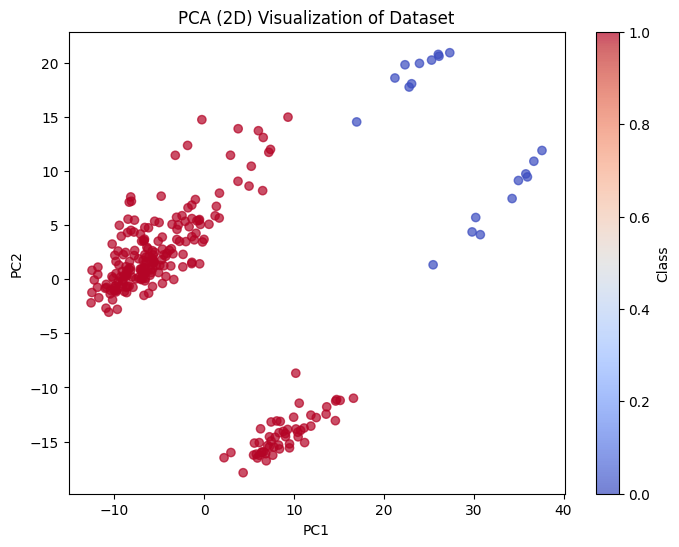


Model Comparison for Linearity Check:
Logistic Regression (Linear): 1.0000
SVM with RBF Kernel (Non-linear): 1.0000

✅ Data might be Linearly separable (Logistic Regression performs similar or better).


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# ==== 1. Load Your Dataset ====
# Replace with your CSV file
data = pd.read_csv("/kaggle/input/ready-to-classifier/combined_top421_common_genes_lasso.csv")

# Assuming last column is the target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# ==== 2. Standardize Features ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==== 3. PCA Visualization ====
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.title('PCA (2D) Visualization of Dataset')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Class')
plt.show()

# ==== 4. Train-Test Split ====
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ==== 5. Train Logistic Regression (Linear Model) ====
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)

# ==== 6. Train RBF SVM (Non-linear Model) ====
svm_rbf = SVC(kernel='rbf', C=1, gamma='scale')
svm_rbf.fit(X_train, y_train)
y_pred_svm = svm_rbf.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)

# ==== 7. Print Accuracy Results ====
print("\nModel Comparison for Linearity Check:")
print(f"Logistic Regression (Linear): {acc_lr:.4f}")
print(f"SVM with RBF Kernel (Non-linear): {acc_svm:.4f}")

if acc_svm > acc_lr + 0.05:
    print("\n✅ Data appears to be Non-linear (RBF SVM performs better).")
elif acc_lr >= acc_svm:
    print("\n✅ Data might be Linearly separable (Logistic Regression performs similar or better).")
else:
    print("\n⚠️ Data might have mild non-linearity.")


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from statsmodels.tools import add_constant

# ==== 1. Load Your Dataset ====
data = pd.read_csv("/kaggle/input/tittititit/combined_top421_common_genes_mrmrsvmrfe.csv")

# Assuming last column is the target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# ==== 2. Standardize Features ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# ==== 3. Train-Test Split ====
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ==== 4. Train Logistic Regression (Linear Model) ====
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)

# ==== 5. Train RBF SVM (Non-linear Model) ====
svm_rbf = SVC(kernel='rbf', C=1, gamma='scale')
svm_rbf.fit(X_train, y_train)
y_pred_svm = svm_rbf.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)

# ==== 6. Print Accuracy Results ====
print("\nModel Comparison for Linearity Check:")
print(f"Logistic Regression (Linear): {acc_lr:.4f}")
print(f"SVM with RBF Kernel (Non-linear): {acc_svm:.4f}")

if acc_svm > acc_lr + 0.05:
    print("✅ Data appears to be Non-linear (RBF SVM performs better).")
elif acc_lr >= acc_svm:
    print("✅ Data might be Linearly separable (Logistic Regression performs similar or better).")
else:
    print("⚠️ Data might have mild non-linearity.")

# ==== 7. Box–Tidwell Test (Logit Linearity Assumption) ====
print("\nRunning Box–Tidwell Test (this may take a few seconds)...")

# Add interaction terms: feature * log(feature)


print("\nBox–Tidwell Test (per feature):")
violations = []

for col in X_scaled.columns[:20]:  # test first 20 features (expand later)
    try:
        X_bt = pd.DataFrame()
        X_bt[col] = X_scaled[col]
        X_bt[col + "_log"] = X_scaled[col] * np.log(np.abs(X_scaled[col]) + 1e-5)
        X_bt = add_constant(X_bt)

        logit_model = sm.Logit(y, X_bt)
        result = logit_model.fit(disp=False)

        pval = result.pvalues[col + "_log"]
        if pval < 0.05:
            violations.append((col, pval))
    except Exception as e:
        print(f"⚠️ Skipped {col}: {e}")

if len(violations) == 0:
    print("✅ No significant non-linearity detected (logit-linearity holds).")
else:
    print("⚠️ Non-linearity detected in these features:")
    for v in violations:
        print(f"{v[0]} (p={v[1]:.4e})")



Model Comparison for Linearity Check:
Logistic Regression (Linear): 1.0000
SVM with RBF Kernel (Non-linear): 1.0000
✅ Data might be Linearly separable (Logistic Regression performs similar or better).

Running Box–Tidwell Test (this may take a few seconds)...

Box–Tidwell Test (per feature):
⚠️ Non-linearity detected in these features:
ACTB (p=2.6544e-05)
AGRN (p=1.0887e-04)
AKAP13 (p=1.7359e-03)
AKT3 (p=1.5870e-04)
APIP (p=1.8252e-04)
APPL1 (p=9.0747e-07)
ARFIP1 (p=2.8866e-04)


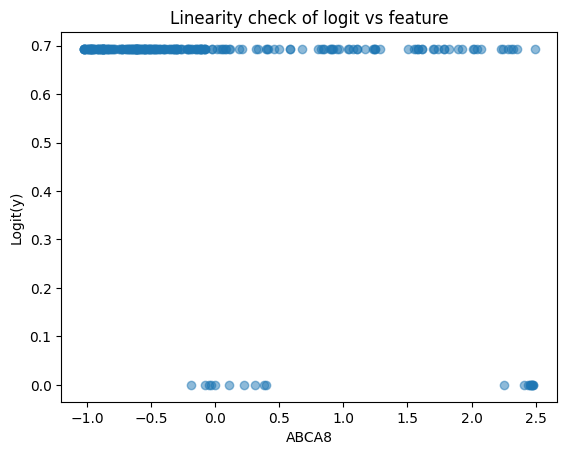

In [12]:
import matplotlib.pyplot as plt

feature = X_scaled.columns[0]  # pick first feature (or one with violation)
plt.scatter(X_scaled[feature], np.log(y + 1), alpha=0.5)
plt.xlabel(feature)
plt.ylabel("Logit(y)")
plt.title("Linearity check of logit vs feature")
plt.show()
